In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torchvision.transforms import v2 as transforms
import random
from tqdm import tqdm

from simclr_play import (
    GaussianBumpDataset,
    SimCLRDataTransform,
    SimCLREncoder,
    SimCLR,
    train_simclr,
    visualize_representations,
    visualize_dataset_samples,
    visualize_augmentations
)

# Set random seeds for reproducibility
seed = None
if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
img_size = 64
dataset = GaussianBumpDataset(num_samples=1000, img_size=img_size, bump_intensity=1.0, noise_level=0.1, border=4)
transform = SimCLRDataTransform(max_translation=0.1, max_shear=30, noise_level=0.1)
simclr_dataset = [(transform(img), position) for img, position in dataset]

batch_size = 64
data_loader = DataLoader(simclr_dataset, batch_size=batch_size, shuffle=True)

# Create the model
hidden_dim = 8
output_dim = 4
projection_dim = 8
high_temperature = 0.5
low_temperature = 0.25

encoder_hitemp = SimCLREncoder(in_size=img_size, hidden_dim=hidden_dim, output_dim=output_dim)
encoder_lotemp = SimCLREncoder(in_size=img_size, hidden_dim=hidden_dim, output_dim=output_dim)
model_hitemp = SimCLR(encoder_hitemp, projection_dim=projection_dim, temperature=high_temperature)
model_lotemp = SimCLR(encoder_lotemp, projection_dim=projection_dim, temperature=low_temperature)
model_hitemp = model_hitemp.to(device)
model_lotemp = model_lotemp.to(device)

# Create the optimizer
learning_rate = 1e-3
optimizer_hitemp = optim.Adam(model_hitemp.parameters(), lr=learning_rate)
optimizer_lotemp = optim.Adam(model_lotemp.parameters(), lr=learning_rate)

# Train the model
print("Training the model...")
epochs = 100
alpha = 1.0
beta = 1.0
losses_hitemp = train_simclr(model_hitemp, data_loader, optimizer_hitemp, epochs=epochs, alpha=alpha, beta=beta)
losses_lotemp = train_simclr(model_lotemp, data_loader, optimizer_lotemp, epochs=epochs, alpha=alpha, beta=beta)

Training the model...


Training the SimCLR model: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s, loss=2.89]


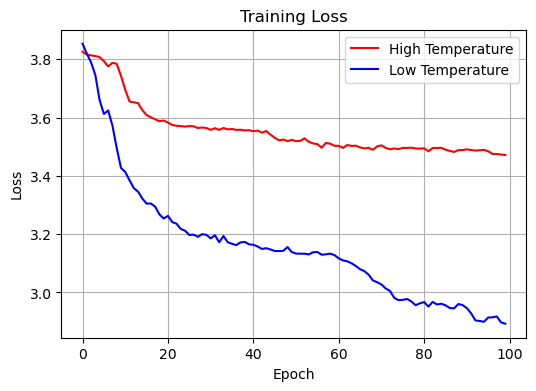

In [21]:
# Plot the loss curve
plt.figure(figsize=(6, 4))
plt.plot(losses_hitemp, color="red", label="High Temperature")
plt.plot(losses_lotemp, color="blue", label="Low Temperature")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

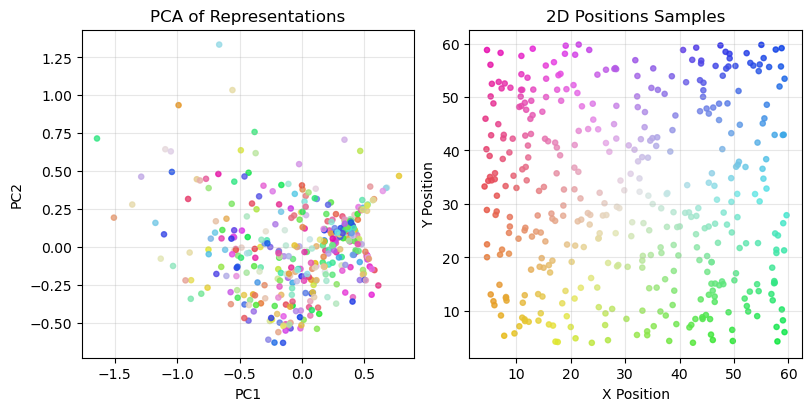

In [22]:
visualize_representations(model_hitemp, dataset, num_samples=400)

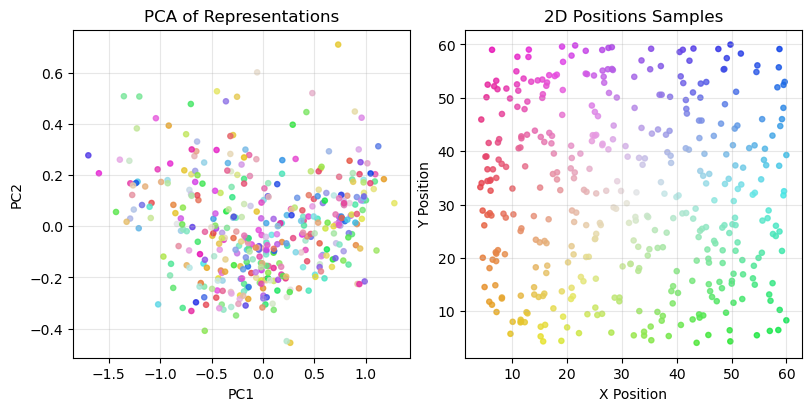

In [23]:
visualize_representations(model_lotemp, dataset, num_samples=400)